In [1]:

%matplotlib inline

import os
from glob import glob
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
 
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Dense, concatenate

from tensorflow.keras.layers import Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix
from tensorflow.keras.callbacks import Callback
import cv2
import time

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:

def read_data(directory):
# =============================================================================
#  This function gets a directory name and returns all images in it concatenated 
#  to each other
# =============================================================================    
    data_list = glob(os.path.join(directory ,r'*.png'))
    #print(os.path.join(directory,'*.png'))
    data = np.asarray([cv2.imread(img,0) for img in data_list])
    return data


In [3]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
# display COCO categories and supercategories
# cats = coco.loadCats(coco.getCatIds())
# nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [5]:

# the index of the image from the set just to visualize

img_idx = 0

dataDir = "E:\Documents\Study\Deep Learning\Project\DATA"
train_data_name = "train2017"
val_data_name = "val2017"

# we resize the images because of memory limitations on my 32GB RAM and 4GB GPU memory
img_width = 64
img_height = 64

# size of the data set for debug {None => all the data} 
max_cnt_debug_train = None
max_cnt_debug_test = None

# load images in grayscale or in RGB when rgb_on = 1 it will load rgb images
rgb_on = 1

# parameters for the training model number of classes will be autometicly generated based on the number of categories
lr =          1e-3        # learning rate 
beta_1 =      0.9         # beta 1 - for adam optimizer
beta_2 =      0.99        # beta 2 - for adam optimizer
epsilon =     1e-7        # epsilon - for adam optimizer
epochs =      50          # number of epochs
bs =          32          # batch size
dp =          0.5         # dropout probability


# in the .getCatIds(catNms=[list of all ids we want to filter from the data]);
categories_names = ['person']


loading annotations into memory...
Done (t=13.12s)
creating index...
index created!


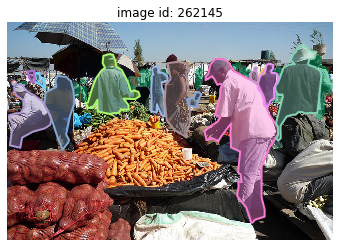

In [6]:

# load captions
#coco_caps= COCO(os.path.join(dataDir,r"annotations\captions_" + data_name + ".json"))

# Load insatnces -> here we take the masks
coco_instances = COCO(os.path.join(dataDir,r"annotations\instances_" + train_data_name + ".json"))

# Load key points
#coco_key_p = COCO(os.path.join(dataDir,r"annotations\person_keypoints_" + data_name + ".json")) 

# get the id for each category specified
catIds = coco_instances.getCatIds(catNms=categories_names);

#get all image id in the directory
all_imgIds = coco_instances.getImgIds()

# get all the image id for all images based on the filter
imgIds = coco_instances.getImgIds(catIds=catIds);

# get the data for each image id with specified annotations
img_data = coco_instances.loadImgs(imgIds)

# Visualize the img_idx specified up here
I = io.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgIds[img_idx]).zfill(12) + ".jpg"))
plt.imshow(I); 
plt.axis('off')
plt.title("image id: " + str(imgIds[img_idx]))

# and show the mask on top of the image
annIds = coco_instances.getAnnIds(imgIds=imgIds[img_idx], catIds=catIds, iscrowd=None)
anns = coco_instances.loadAnns(annIds)
coco_instances.showAnns(anns)

#plot key points
#annIds_keys = coco_key_p.getAnnIds(imgIds=imgIds[idx], catIds=catIds, iscrowd=None)
#anns_keys = coco_key_p.loadAnns(annIds_keys)
#coco_key_p.showAnns(anns_keys)

#print the caption
#annIds = coco_caps.getAnnIds(imgIds=imgIds[idx]);
#anns = coco_caps.loadAnns(annIds)
#coco_caps.showAnns(anns)

(-0.5, 639.5, 426.5, -0.5)

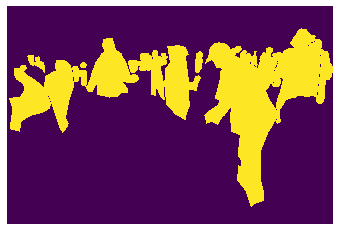

In [7]:

#visualize the mask of the annotaion
# every annotation has a id (number) for every pixel on the mask we multiply by id
# pixel = id = we have annotation in the pixel
# pixel = 0 we dont have annotation in that spot
anns_img = np.zeros((img_data[img_idx]['height'],img_data[img_idx]['width']))
for ann in anns:
    #mask += coco_instances.annToMask(anns[i])*anns[i]['category_id'] 
    anns_img = np.maximum(anns_img, coco_instances.annToMask(ann)*ann['category_id'])
    
#plt.subplot(2,1,1)    
plt.imshow(anns_img)
plt.axis('off')
#plt.subplot(2,1,2)
# Visuaslize the histogram of the mask
#plt.hist(anns_img.ravel(),256, [0,50]);

In [8]:

mask_list = [] # init empty list for masks

# we load all the images in grayscale because of memory limitations
img_list = [] # init empty list to store all the image data

for cnt, imgID in enumerate(all_imgIds):
    I = cv2.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgID).zfill(12) + ".jpg"), rgb_on)
    I = cv2.resize(I, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    img_list.append(I)
    
    if (imgID in imgIds):
        # get all annotation ids for img id
        annIds = coco_instances.getAnnIds(imgIds=imgID, catIds=catIds, iscrowd=None) 
        # load all annotation inside the image
        anns = coco_instances.loadAnns(annIds) 
        # image data for image specification width height etc..
        #img_data = coco_instances.loadImgs(imgID)[0] 
    
        # init empty mask
        anns_img = np.zeros((img_height, img_width),) 
        for ann in anns:
            # resize the mask of the  specific anotation in the image
            mask_res = cv2.resize(coco_instances.annToMask(ann), (img_height, img_width), interpolation = cv2.INTER_AREA )
            # add the mask multiplid by the category index for category 
            # here we multiply by the index of the annotation +1
            # for easier way to_categories
            # if we have only one category it will be mask of only zeros ans ones
            # if we would multiply by the category id the to_category will make more categories then we need
            # for example if the category is 17 it will generate 18 categories and we need only 2
            anns_img = np.maximum(anns_img, mask_res*(catIds.index(ann['category_id'])+1))
    else:
        anns_img = np.zeros((img_height, img_width),)
    # for debug save the mask to the disk
    #cv2.imwrite(r"E:\Documents\Study\Deep Learning\Project\MASKS\\" +str(imgID).zfill(12) + ".png" , anns_img)
    mask_list.append(anns_img)
    
    if (cnt+1 == max_cnt_debug_train):
        break

# read the masks from the disk
#y_train = read_data(r'E:\Documents\Study\Deep Learning\Project\MASKS')
#y_train = (to_categorical(y_train)).astype('float')

y_train = np.asarray(mask_list)
y_train = (to_categorical(y_train, num_classes=None, dtype='float32')).astype('float')

x_train = np.asarray(img_list)
if (rgb_on == 0):
    x_train = (np.expand_dims(x_train, axis=3)).astype('float')

print('y_train shape:', y_train.shape)
print('x_train shape:', x_train.shape)

y_train shape: (118287, 64, 64, 2)
x_train shape: (118287, 64, 64, 3)


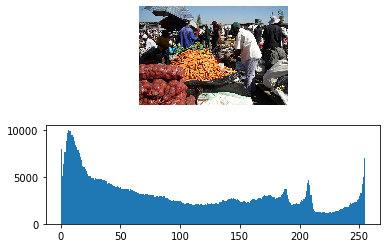

In [9]:
#visualize the first image from the set
I = io.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgIds[0]).zfill(12) + ".jpg"))
#I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)

#Visualize the image
plt.subplot(2,1,1)    
plt.imshow(I)
plt.axis('off')
#visualize the histogram of the image
plt.subplot(2,1,2)   
plt.hist(I.ravel(),256, [0,255]);

In [10]:
# number of classes for prediction based on the to_categorial
num_of_clss = y_train.shape[3]  # number of classes (the number of the categories form the to_categorial by keras)


In [11]:
inp = Input(shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3]))

# First conv block
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inp)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dp)(x)

# Second conv block
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Third conv block
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dp)(x)
# DECONV AND UNPOOLING

x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

out = Conv2DTranspose(num_of_clss, (3, 3), strides=(1, 1), padding='same', activation = 'softmax')(x)

model = Model(inp,out)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464 

In [13]:
# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])



In [14]:
time_callback = TimeHistory()
history = model.fit(x_train, y_train, validation_split=0.3, epochs=epochs, batch_size=bs, callbacks=[time_callback])
times = time_callback.times
print(times)

Train on 82800 samples, validate on 35487 samples
Epoch 1/50
82800/82800 [==============================] - 150s 2ms/sample - loss: 0.2352 - accuracy: 0.9131 - val_loss: 0.2339 - val_accuracy: 0.9200 - ETA: 2:52 - los - ETA:  - ETA: 2:17 - - ETA - ETA: 2:06 - loss: 0.2740 -  - ETA: 2:05 - loss: 0.2737 - accura - ETA: 2:04 - loss: - ETA - ETA: 1:54 - loss: 0 - ETA: 1:52 - loss: 0.2700 - accuracy: 0.90 - ETA: 1:52 - loss: 0.2699 - accuracy:  - ETA: 1:52 - loss: 0.2697 - accuracy: 0. - ETA: 1:52 - l - ETA: 1:50 - l - ETA: 1:48 - loss: 0.268 - ETA: 1:47 - loss: 0.2673 -  - ETA: 1:46 - loss: - ETA: 1:40 - loss: 0.2641 -  - ETA: 1:39 - loss: 0.2 - ETA: 1:34 - l
Epoch 2/50
82800/82800 [==============================] - 145s 2ms/sample - loss: 0.2036 - accuracy: 0.9211 - val_loss: 0.1989 - val_accuracy: 0.9244
Epoch 3/50
82800/82800 [==============================] - 147s 2ms/sample - loss: 0.1923 - accuracy: 0.9253 - val_loss: 0.1818 - val_accuracy: 0.9299 - loss: 0 - ETA: 18s - loss: 0.1929 

82800/82800 [==============================] - 144s 2ms/sample - loss: 0.1685 - accuracy: 0.9345 - val_loss: 0.1583 - val_accuracy: 0.9383accura - ETA: 1:50 - loss: 0.1 - ETA: 1:49 - loss: 0.1706 - accura - ETA: 1:48 - loss: 0.1707 - accura - ETA: 1:48 - loss: 0.1703 - ac - ETA: 1:45 - loss: 0.1693 - accura - ETA:  - ETA: 1:43 - loss: 0.1697 - accuracy: 0.93 - ETA: 1:43 - loss: 0.1698  - ETA: 1:42 - loss: 0 - ETA: 1:41 - loss: 0.1695 - accuracy:  - ETA: 1:41 - loss: 0.1 - ETA: 1:40 - loss: 0.1 - ETA: 1:32 - loss: 0.1690 - ac - ETA: 1:31 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:31 - loss: 0.1691 - accuracy - ETA: 1:31 - loss: 0.1689 - ac - ETA: 1:30 - loss: 0.169 - ETA: 1:30 - los - ETA: 1:28 - loss: 0.1689 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1689 - accuracy - ETA: 1:28 - loss: 0.1689 - accuracy:  - ETA: 1:28 - loss: 0.1688 - accuracy: 0. - ETA: 1:25 - loss: 0 - ETA: 1:24 - loss: 0.1687  - ETA: 1:24 - loss: 0.1690 - accuracy:  - ETA: 1:23 - loss: 0.1 - ETA: 1:20 - loss: 0 - ETA: 1:17

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1638 - accuracy: 0.9362 - val_loss: 0.1621 - val_accuracy: 0.9378 loss: 0.1659 -  - ETA: 1:43 - loss: 0.1659  - ETA: 1:42 - loss: 0.1657 - accuracy: 0.93 - ETA: 1:18 - loss: 0.1653 - accuracy - E - ETA:  - ETA: 1:10 - loss: 0.164 - ETA: 1:09 - loss: 0.1641 - accuracy: 0. - ETA - ETA: 59s - loss: 0.1644 - a - ETA: 58s - loss: 0.1644 - accuracy:  - ETA: 57s - loss: 0.1644 - accu - ETA: 56s - loss: - ETA: 26s - loss: 0.1634 - - ETA: 25 - E - ETA: 0s - loss: 0.1638 
Epoch 13/50
82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1626 - accuracy: 0.9366 - val_loss: 0.1621 - val_accuracy: 0.93808 - ETA: 42s -  - ETA: 39s - loss:  - ETA: 37s - loss: - ETA: 35s - loss: 0.1628 - accur  - ETA: 14s - loss -
Epoch 14/50
82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1609 - accuracy: 0.9371 - val_loss: 0.1537 - val_accuracy: 0.9404 - ETA: 55s - l  - ETA: 48s - loss: 0.1605 - accur

82800/82800 [==============================] - 144s 2ms/sample - loss: 0.1535 - accuracy: 0.9399 - val_loss: 0.1445 - val_accuracy: 0.94445 - accuracy: 0.94 - E - - ETA: 1:47 - - ETA - ETA: 1:41 - loss: 0.1526 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1526 - accuracy:  - ETA: 1:40 - loss: 0.1526 -  - ETA: 1:40 - los - ETA - ETA: 1:37 - loss: 0.1518  - ETA: 1:36 - los - ETA: 1:35 - loss: 0.1522 - accuracy: 0.94 - ETA: 1:35 - loss: 0.1521 -  - ETA: 1:34 - loss: 0.1523 - accuracy: 0.94 - ETA: 1:34 - loss: 0.1523 - accura - ETA: 1:33 - loss: - ETA: 1: - ETA: 1:31 - loss: 0.1521 -  - ETA: 1:30 - loss: 0.1521 - accuracy: 0.94 - ETA: 1:30 - loss: 0.1523 - accuracy:  - ETA: 1:23 - loss: 0.1 - ETA: 1:23 - - ETA: 1:21 - loss: 0 - ETA: 1:18 - loss: 0.1519 - ac - ETA: 1:18 - los - ETA: 1:16 - loss: 0.1518  - ETA: 1:16 - loss: 0.1519 - accuracy: 0. - ETA: 1:15 - loss: 0.1519 - accu - ETA: 1:15 - loss: 0.1520 -  - ETA: 1:14 - loss: 0.1521  - ETA: 1:07 - - ETA: 1:06 - loss: 0.1530 - accuracy: 0. - ETA: 

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1517 - accuracy: 0.9406 - val_loss: 0.1429 - val_accuracy: 0.9445 - loss: 0.1502 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1500 - accura - ETA: 1:50 - loss: 0.1502 - accu - ETA: 1:50 - loss: 0.1499 -  - ETA: 1:49 - loss: 0.1498 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1499 - accuracy: 0. - ETA - ETA: 1:47 - loss: 0.1517 - accuracy: 0. - ETA: 1:47 - loss: - ETA: 1:46 - loss: 0.1513 - accuracy: 0. - ETA: 1:38 - loss: 0.1523 - ac - ETA: 1:37 - loss: - ETA: 1:36 - loss: 0.1523 - accuracy: 0. - ETA: 1:36 - loss: 0.1522 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1521 - ac - ETA: 1:31 - loss: 0.151 - ETA: 1:30 - loss: 0.1516 - accuracy:  - ETA: 1:30 - loss: 0.1517 - accura - ETA: 1:30 - loss: 0.1516 - accuracy - ETA: 1:29 - loss: 0.1517 - accuracy: 0. - ETA: 1:29 - loss: 0.1517 - accuracy: 0. - ETA: 1:29 - loss: 0.1516 -  - ETA: 1:22 - loss: 0.1517 - accuracy:  - ETA: 1:22 - loss: 0.1516 - accu - ETA: 1:21 - loss: 0.1514 - accura

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1511 - accuracy: 0.9409 - val_loss: 0.1447 - val_accuracy: 0.943444 - loss: 0.1497 - accura - ETA: 1:43 - loss: 0.1495 - accuracy: 0. - ETA: 1:43 - loss: 0.1492 - accuracy: 0. - ETA: 1:43 - loss: 0.1492 - accuracy: 0. - ETA: 1:43 - loss: 0.1492  - ETA: 1:42 - loss: 0.1493 - accuracy: 0.94 - ETA:  - ETA: 1:36 - loss: 0.1508 - accuracy - ETA: 1:36 - loss: 0.1 - ETA: 1:35 - loss: - ETA: 1:33 - ETA: 1:32 - loss: 0.1499 - accuracy:  - ETA: 1:32 - loss: - ETA: 1:30 - loss: 0.1498 - accuracy: 0.94 - ETA: 1:30 - loss: 0.1498 - ac - ETA: 1:30 - loss: 0 - ETA: 1:29 - loss: 0.1503 - accuracy: 0.94 - ETA: 1:29 - loss: - ETA: 1:27 - loss: 0.1503 - accuracy: 0. - ETA: 1: - ETA: 1:26 - loss: 0.1506 - accuracy - ETA: 1:25 - loss: 0.1505 - accu - ETA: 1:25 - loss: 0.1506 - accuracy - - ETA: 1:22 - loss: 0.1504 - accuracy:  - ETA:  - ETA: 1:21 - los - ETA: 1:19 - loss: 0.1508 - accuracy: 0.94 - ETA: 1:19 - l - ETA: 1:14 - loss: 0.1

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1498 - accuracy: 0.9413 - val_loss: 0.1422 - val_accuracy: 0.9444: 2:00 - loss: 0.1521 - accuracy: 0.94 - ETA: 2:00 - loss: 0.1510 - accuracy - ETA: 1:59 - ETA: 1:52 - loss: 0.1484 - accuracy: 0. - ETA: 1:52 - loss: 0.1478 - accuracy - ETA: 1:51 - loss: 0.1479 - accuracy: 0. - ETA: 1:51 - loss: 0.147 - ETA: 1:50 - l - ETA: 1:49 - loss: 0.148 - ETA: 1:48 - loss: 0.1483 -  - ETA: 1:48 - loss: 0.1493 - accuracy:  - ETA: 1:45 - loss: 0.1487 - accuracy:  - ETA:  - ETA: 1:43 - loss: 0.1 - ETA: 1:40 - loss: 0.1487 - accuracy - ETA: 1:40 - loss: 0.1484 - accuracy: 0. - ETA: 1:40 - loss: 0 - ETA: 1: - ETA: 1:37 - - - ETA: 1:24 - loss: 0.1491 - accuracy: 0.94 - ETA - ETA: 1:22 - loss: 0.1493 - ac - ETA: 1: - ETA: 1:20 - loss: - ETA: 1:19 - loss: 0.1493 -  - ETA: 1:18 - loss: 0.1493 - accuracy: 0. - ETA: 1:18 - loss: 0.1493 - accu - ETA: 1:17 - loss: 0.1493 - accuracy:  - ETA: 1:17 - loss: 0.1492 - accuracy: 0.94 - ETA: 1:17

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1487 - accuracy: 0.9417 - val_loss: 0.1430 - val_accuracy: 0.9441.154 - ETA: 2:01 - loss: 0 - ETA: 2:00 - loss: 0.1519 - accuracy:  - ETA: 1:59 - loss: 0.1 - ETA: 1:58 - loss: 0.1501 - accuracy: 0.94 - ETA: 1:58 - - ETA: 1:56 - loss: 0.1501 - accuracy - ETA: 1:55 - loss: 0.1508 - accuracy - ETA: 1:50 - loss: 0.1486 - accura - ETA: 1:50 - loss: 0 - ETA: 1:49 - loss: 0.1484 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1 - ETA: 1:41 - loss: - ETA: 1:18 - loss: - ETA: 1:17 - ETA: 1:16 - loss: 0 - ETA: 1:15 - loss: 0.1481 - accura - ETA: 1:14 - loss: 0.1481  - ETA: 1:13 - loss: 0.1481 - accu - ETA: 1:13 - loss: 0.1481  - ETA: 1:12 - loss: 0.1486  - ETA: 1:11 - loss: 0.1487 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1487 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1487 -  - ETA: 1:10 - loss: 0.1484  - ETA: 1:10 - loss: 0 - ETA: 1:09 - loss: 0.1483 - accuracy - ETA:  - ETA: 1:07 - loss: 0.1486 - accu - ETA: 1:04 - loss: 0.1488 - accura

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1482 - accuracy: 0.9420 - val_loss: 0.1408 - val_accuracy: 0.9447 loss: 0.1442 - accuracy - ETA:  - ETA: 2:00 - loss: 0.1457 - accuracy:  - ETA: 1:59 - loss: 0.1 - ETA: 1:54 - loss: 0.1457 - ac - ETA: 1:54 - loss: 0.1454  - ETA: 1:53 - loss: 0.1450  - - ETA: 1:46 - loss: 0.1466 -  - ETA: 1:44 - loss: 0.1 - ETA: 1:43 - loss: 0.1483 - accura - ETA: 1:40 - loss: 0.1 - - ETA: 1:37 - loss: 0.1 - ETA: 1:37 - loss: 0.1470 -  - ETA: 1:36 - loss: - ETA: 1:35 - loss: 0.1472 - accuracy - ETA: 1:34 - loss: 0.1472  - ETA: 1:30 - loss: 0 - ETA: 1:29 - loss: 0.1475 - accuracy: 0.94 - ETA: 1:29 - loss: 0.1477 - accuracy: 0.94 - ETA - ETA: 1:27 - loss: 0.1476 -  - ETA: 1:24 - loss: 0.1479 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1479 - accuracy - ETA: 1:24 - ETA: 1:22 - loss: 0.1479 - accuracy:  - ETA: 1:22 - loss: 0 - ETA: 1:19 - loss: 0.147 - ETA: 1:18 - los - ETA: 1:15 - loss: 0.1479 - accu - ETA: 1:14 - loss: - ETA: 1:13 - loss:

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1471 - accuracy: 0.9424 - val_loss: 0.1411 - val_accuracy: 0.9454TA: 1:58 - loss: 0.1470 - accuracy: 0. - ETA: 1:58 - loss: 0.1459 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1 - ETA: 1:57 - loss: 0.1485 - ac - ETA: 1:54 - loss: 0.1464 - accuracy - ETA - ETA: 1:52 - l - ETA: 1:51 - loss: - ETA: 1:49 - loss: 0.1477 - accuracy: 0. - ETA: 1:49 - loss: 0.1476 - accu - ETA: 1:49 - loss: 0.1478 - accuracy: 0. - ETA: 1:49 - loss: 0.1482 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1481 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1480 -  - ETA: 1:48 - loss: 0.1477 - accuracy:  - ETA: 1:47 - loss: 0 - ETA: 1:46 - loss: 0.1476  - ETA - ETA: 1:44 - loss: 0.1454 - accuracy:  - ETA: 1:44 - loss: 0.1457  - ETA: 1:43 - loss: 0.1 - ETA: 1:42 - loss: 0.1459 - accuracy - ETA: 1:42 - loss: 0.1457 - accuracy: 0. - ETA: 1:41 - loss: 0.1 - ETA:  - ETA: 1: - ETA: 1:33 - loss: 0.1 - ETA: 1:32 - loss: 0.146 - ETA: 1:31 - loss: 0.1463 - accura - ETA: 1:31

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1470 - accuracy: 0.9422 - val_loss: 0.1432 - val_accuracy: 0.9453oss: 0.1301 - ac - ETA: 2:01 - loss: 0.1345 - accu - ETA: 2:01 - loss: 0.1422  - ETA: 2:00 - loss: 0.1459 - accuracy: 0.94 - ETA: 2:00 - loss: 0.1456 - accuracy: 0. - ETA: 2:00 - loss: 0.1443  - ETA: 1:59 - loss: 0.1456 - accuracy:  - ETA: 1:59 - loss: 0.1446 -  - ETA: 1:58 - los - ETA: 1:57 - loss: 0.1415 - accura - ETA: 1:56 - - ETA: 1:47 - loss: 0.1464 - ac - - ETA: 1:42 - loss: 0.1467 - accuracy - ETA: 1:42 - loss: 0.1467 - accuracy: 0. - ETA: 1:42 - loss: 0.1465 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1464 - accura - ETA: 1:41 - loss: 0.1463 - accu - ETA: 1: - ETA: 1:27 - loss: 0.1456 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1456 - accuracy - E - ETA: 1:25 - loss: 0.1453 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1 - ETA: 1:23 - loss: 0.1458 - accu - ETA: 1:23 - - ETA: 1:22 - loss: 0.1458 - accuracy: 0.94 - ETA: 1:22 - loss: 0.1457 - accuracy: 0.94 - E

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1467 - accuracy: 0.9425 - val_loss: 0.1464 - val_accuracy: 0.9445 ETA: 2:00 - loss: 0.1443 - accuracy - ETA: 2:00 - loss: 0.1470 - accuracy: 0. - ETA: 1:59 - loss: 0.1483 - accuracy:  - ETA: 1:59 - loss: 0.1506 - accura - ETA: 1:57 - loss: 0.1470 - accuracy: 0.94 - ETA: 1:56 - loss: 0.1475  - ETA: 1:56 - loss: 0.1468  - ETA: 1:55 - loss: 0.1459 - ac - ETA: 1:54 - loss: 0.144 - ETA:  - ETA: 1:38 - loss: 0.1458 - accuracy: 0.94 - ETA: 1:37 - - ETA:  - ETA: 1:32 - loss: 0.1459 - accuracy: 0. - ETA: 1:32 - loss: 0.1 - ETA: 1:31 - loss: 0.1460 - accuracy: 0. - ETA: 1:31 - loss: 0.1459 - ac - ETA: 1:30 - loss: 0 - ETA: 1:27 - loss: 0.1468 - accuracy - ETA: 1:27 - loss: 0.1467 - accu - ETA: 1:27 - loss: 0.1466 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1465 - accuracy: 0.94 - ETA: 1:26 - loss: 0.146 - ETA: 1:26 - loss: 0.1466 - accuracy:  - ETA: 1:25 - loss: 0.1467 -  - ETA: 1:25 - loss: 0.1468 - ac - ETA: 1:24 - loss: 0.146

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1459 - accuracy: 0.9429 - val_loss: 0.1421 - val_accuracy: 0.9456: 2:03 - ETA: 1:58 - - ETA: 1:55 - loss: 0.142 - ETA: 1:54 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:54 - loss: 0.141 - ETA: 1:54 - los - ETA: 1:52 - loss: 0.1439 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1440 - accuracy: 0.94 - ETA: 1:52 - loss: - ETA: 1:45 - loss: 0.1427 - ac - ETA: 1:42 - ETA: 1:40 - ETA: 1:39 - loss: 0.142 - ETA: 1:38 - loss: 0.1423 - accuracy:  - ETA: 1:38 - loss: 0.1420 - accuracy:  - ETA: 1:37 - loss: 0.1421  - ETA: 1:37 - loss: 0.1418 - accuracy:  - ETA: 1:36 - loss: 0.1417 - ac - ETA: 1:34 - loss: 0.1421  - ETA: 1:29 - loss: 0.1430 - accuracy:  - ETA: 1:29 - loss: 0.143 - ETA: 1:28 - loss: 0.1433 - ac - ETA: 1:27 - loss: 0.1434 -  - ETA: 1:26 - loss: 0.1437 - accuracy:  - ETA: 1: - E - ETA: 1:22 - loss: 0.1437  - ETA: 1:22 - loss: - ETA: 1:21 - loss: 0.1441 -  - ETA: 1:20 - loss: 0.1443 - accuracy: 0. - ETA: 1:20 - loss: 0.1445 

82800/82800 [==============================] - 143s 2ms/sample - loss: 0.1454 - accuracy: 0.9429 - val_loss: 0.1423 - val_accuracy: 0.9446 loss: 0.1526 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1512 : 4s - loss: 0.1455 - accura - ETA: 3s - loss: 0.145 - ETA: 2s - loss: 0.1
Epoch 48/50


82800/82800 [==============================] - 143s 2ms/sample - : 0.1447 - accuracy:  - ETA: 1s - loss: 0.1447 - accuracy:  - ETA: 1s - loss: 0.144 - ETA: 0s - loss: 0.1447 - accura
[150.4650754928589, 145.48278164863586, 146.7353699207306, 146.60711479187012, 147.79115891456604, 144.65567183494568, 146.43800950050354, 151.83586764335632, 143.90190887451172, 143.96784281730652, 143.1687467098236, 143.15118145942688, 143.19784903526306, 143.0997874736786, 143.19131803512573, 143.27820873260498, 143.13467955589294, 143.10376691818237, 143.17612743377686, 143.1806468963623, 143.16500806808472, 143.1425952911377, 143.77704215049744, 143.9850935935974, 144.16722106933594, 142.68158197402954, 142.58791851997375, 142.71923112869263, 142.63689637184143, 142.74874019622803, 142.78657269477844, 142.90986132621765, 142.82913637161255, 142.6791386604309, 142.588045835495, 142.7462420463562, 142.95446729660034, 142.50835156440735, 142.70294952392578, 142.84971690177917, 142.85923099517822, 142.887

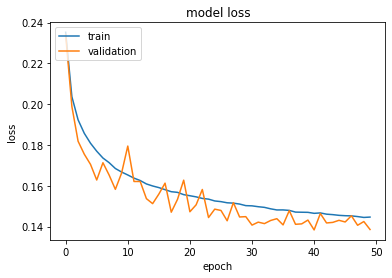

In [15]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show(); plt.close()

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [18]:
#load for validation different directrory different ids
coco_instances = COCO(os.path.join(dataDir,r"annotations\instances_" + val_data_name + ".json"))

# in the .getCatIds(catNms=[list of all ids we want to filter from the data]);
catIds = coco_instances.getCatIds(catNms=categories_names);

# get all the image id for all images here its for the validation
all_imgIds = coco_instances.getImgIds();

# get all the image id for all images based on the filter
imgIds = coco_instances.getImgIds(catIds=catIds);

img_list = []
mask_list = []

for cnt, imgID in enumerate(all_imgIds):
    I = cv2.imread(os.path.join(dataDir, val_data_name +r"//" +str(imgID).zfill(12) + ".jpg"),rgb_on)
    I = cv2.resize(I, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    img_list.append(I)
    
    if (imgID in imgIds):
        annIds = coco_instances.getAnnIds(imgIds=imgID, catIds=catIds, iscrowd=None)
        anns = coco_instances.loadAnns(annIds)
        img_data = coco_instances.loadImgs(imgID)[0]
        anns_img = np.zeros((img_height, img_width),)
        for ann in anns:
            mask_res = cv2.resize(coco_instances.annToMask(ann), (img_height, img_width), interpolation = cv2.INTER_AREA )
            anns_img = np.maximum(anns_img, mask_res*(catIds.index((ann['category_id']))+1))
        
        #mask = cv2.resize(anns_img, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)    
        #save mask to disk
        #cv2.imwrite(r"E:\Documents\Study\Deep Learning\Project\TestMASKS\\" +str(imgID).zfill(12) + ".png" , mask)
    else:
        anns_img = np.zeros((img_height, img_width),)
        
    mask_list.append(anns_img)
    
    if (cnt+1 == max_cnt_debug_test):
        break
    
#y_train = read_data(r'E:\Documents\Study\Deep Learning\Project\MASKS')
#y_train = (to_categorical(y_train)).astype('float')

y_test = np.asarray(mask_list)
#y_test = (np.expand_dims(y_test, axis=3)).astype('float')
y_test = (to_categorical(y_test, num_classes=2, dtype='float32')).astype('float')


x_test = np.asarray(img_list).astype('float')

if (rgb_on == 0):
    x_test = (np.expand_dims(x_test, axis=3)).astype('float')

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


loading annotations into memory...
Done (t=1.52s)
creating index...
index created!
x_test shape: (5000, 64, 64, 3)
y_test shape: (5000, 64, 64, 2)


(-0.5, 63.5, 63.5, -0.5)

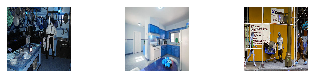

In [19]:
plt.subplot(3,3,1)
plt.imshow(np.squeeze(x_test[0,:,:].astype('uint8')))
plt.axis('off')

plt.subplot(3,3,2)
plt.imshow(np.squeeze(x_test[1,:,:].astype('uint')))
plt.axis('off')

plt.subplot(3,3,3)
plt.imshow(np.squeeze(x_test[2,:,:].astype('uint')))
plt.axis('off')

In [20]:
#plt.hist((coco_instances.annToMask(ann)*49).ravel(),256, [0,255]);
#plt.hist(mask_list[0].ravel(),256, [0,255]);
#plt.imshow(mask_list[0])

In [21]:
y_pred = loaded_model.predict(x_test)

In [22]:
y_pred = model.predict(x_test)
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)


5000/1 [==============================================================================================================================================================================] - 3s 622us/sample - loss: 0.2073 - accuracy: 0.9441


test loss: 0.14534304783344268
test accuracy: 0.9440575


In [23]:
# #Visialize the source image
# img = cv2.imread(os.path.join(dataDir, data_name +r"//" +str(imgIds[0]).zfill(12) + ".jpg"),0)
# plt.imshow(img)

(-0.5, 63.5, 63.5, -0.5)

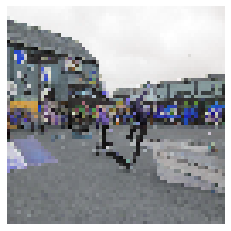

In [24]:
#Visialize the resized image
# visualize the predicted resaults vs the real resaults
img_idx = 3

if (rgb_on == 0):
    plt.imshow((x_test[img_idx,:,:,0]).astype('uint8'))
else:
    plt.imshow((x_test[img_idx,:,:]).astype('uint8'))
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

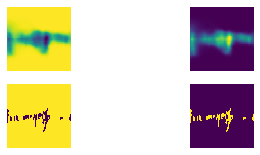

In [25]:
# visualize the predicted resaults vs the real resaults

plt.subplot(3,2,1)
plt.imshow((y_pred[img_idx,:,:,0]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow((y_pred[img_idx,:,:,1]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow((y_test[img_idx,:,:,0]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow((y_test[img_idx,:,:,1]*255).astype('uint8'))
plt.axis('off')


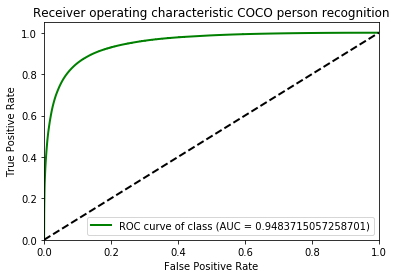

In [26]:
# auc roc for the good model the fist class
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:,:,:,0].flatten(), y_pred[:,:,:,0].flatten())
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='green', lw=lw,label='ROC curve of class (AUC = {0})' ''.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic COCO person recognition')
plt.legend(loc="lower right")
plt.show()


In [27]:
# load 12 layers from the model
layer_outputs = [layer.output for layer in loaded_model.layers] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=loaded_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

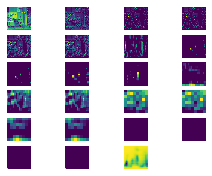

In [28]:
activations = activation_model.predict(x_test) # Returns a list of five Numpy arrays: one array per layer activation
img_idx = 2
plt.matshow(x_test[img_idx, :, :].astype('uint8'))
plt.axis('off')
for idx, act in enumerate(activations):
    plt.subplot(8,4,idx+1)
    plt.imshow(act[img_idx, :, :, 0], cmap='viridis')
    plt.axis('off')
    

